In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFE
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, Isomap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, silhouette_score, adjusted_rand_score, normalized_mutual_info_score, davies_bouldin_score, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from PCA import my_PCA

In [2]:
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

In [3]:
clf_df = pd.read_csv("../data/asteroids_processed.csv")
reg_df = pd.read_csv("../data/cars_processed.csv")

In [4]:
X_clf_df = clf_df.drop(['hazardous'], axis=1)
y_clf_df = clf_df['hazardous']

In [5]:
oversample = SMOTE()
X_clf, y_clf = oversample.fit_resample(X_clf_df, y_clf_df)

In [6]:
X_clf.shape

(149966, 5)

In [51]:
X_reg = reg_df.drop(['price_usd'], axis=1)
y_reg = reg_df['price_usd']

In [52]:
X_reg.shape

(29393, 26)

In [77]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clf)
X_clf = pd.DataFrame(X_scaled, columns=X_clf.columns)

In [54]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reg)
X_reg = pd.DataFrame(X_scaled, columns=X_reg.columns)

In [181]:
table_clf = pd.DataFrame()

In [182]:
def test_clf(X, y, table_name=None):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  cat = CatBoostClassifier().fit(X_train, y_train, verbose=False)
  y_pred = cat.predict(X_test)
  print(classification_report(y_test, y_pred))
  if table_name:
    table_clf.loc[table_name, 'accuracy'] = round(accuracy_score(y_test, y_pred), 4)
    table_clf.loc[table_name, 'precision'] = round(precision_score(y_test, y_pred), 4)
    table_clf.loc[table_name, 'recall'] = round(recall_score(y_test, y_pred), 4)
    table_clf.loc[table_name, 'F1'] = round(f1_score(y_test, y_pred), 2)

In [183]:
test_clf(X_clf, y_clf, 'CatBoost (все признаки)')

              precision    recall  f1-score   support

           0       0.95      0.92      0.94     15001
           1       0.93      0.95      0.94     14993

    accuracy                           0.94     29994
   macro avg       0.94      0.94      0.94     29994
weighted avg       0.94      0.94      0.94     29994



In [78]:
clf_vt = VarianceThreshold(1)
X_clf_vt = clf_vt.fit_transform(X_clf)
X_clf_vt.shape

(149966, 2)

In [79]:
X_clf_vt = pd.DataFrame(X_clf_vt, columns=clf_vt.get_feature_names_out())
X_clf_vt.head()

,miss_distance,absolute_magnitude
0,-1.653494,1.553813
1,-0.204972,0.770733
2,1.291456,0.379193
3,-1.123473,1.162273
4,1.562310,-0.403887


In [184]:
test_clf(X_clf_vt, y_clf, 'VarianceThreshold')

              precision    recall  f1-score   support

           0       0.98      0.82      0.90     14868
           1       0.85      0.99      0.91     15126

    accuracy                           0.91     29994
   macro avg       0.92      0.91      0.91     29994
weighted avg       0.92      0.91      0.91     29994



In [16]:
skb = SelectKBest(k=3)
X_clf_skb = skb.fit_transform(X_clf, y_clf)
X_clf_skb.shape

(149966, 3)

In [17]:
X_clf_skb = pd.DataFrame(X_clf_skb, columns=skb.get_feature_names_out())
X_clf_skb.head()

,est_diameter_min,est_diameter_max,absolute_magnitude
0,-1.251287,-1.260531,1.553982
1,-1.085014,-1.085282,0.770668
2,-0.788098,-0.787888,0.379011
3,-1.215657,-1.218047,1.162325
4,0.209540,0.205194,-0.404302


In [185]:
test_clf(X_clf_skb, y_clf, 'SelectKBest')

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     14900
           1       0.92      0.93      0.93     15094

    accuracy                           0.93     29994
   macro avg       0.93      0.93      0.93     29994
weighted avg       0.93      0.93      0.93     29994



In [19]:
tree = DecisionTreeClassifier().fit(X_clf, y_clf)

In [20]:
rfe = RFE(estimator=tree, n_features_to_select=3, step=1).fit(X_clf, y_clf)
X_clf_rfe = pd.DataFrame(rfe.transform(X_clf), columns=rfe.get_feature_names_out())
X_clf_rfe.head()

,est_diameter_max,relative_velocity,miss_distance
0,-1.260531,0.255561,-1.653686
1,-1.085282,-1.974633,-0.204425
2,-0.787888,0.220498,1.292765
3,-1.218047,-0.415257,-1.123395
4,0.205194,0.794003,1.563758


In [186]:
test_clf(X_clf_rfe, y_clf, 'RFE')

              precision    recall  f1-score   support

           0       0.96      0.90      0.93     15171
           1       0.90      0.96      0.93     14823

    accuracy                           0.93     29994
   macro avg       0.93      0.93      0.93     29994
weighted avg       0.93      0.93      0.93     29994



In [22]:
pca = PCA(n_components=3)
X_clf_pca = pca.fit_transform(X_clf)
X_clf_pca.shape

(149966, 3)

In [187]:
test_clf(X_clf_pca, y_clf, 'PCA')

              precision    recall  f1-score   support

           0       0.99      0.85      0.91     14954
           1       0.87      0.99      0.92     15040

    accuracy                           0.92     29994
   macro avg       0.93      0.92      0.92     29994
weighted avg       0.93      0.92      0.92     29994



In [188]:
sample_indices = np.random.choice(len(X_clf), size=5000, replace=False)
X_sample = X_clf.loc[sample_indices]
y_sample = y_clf.loc[sample_indices]

In [27]:
kpca = KernelPCA(n_components=3, kernel='rbf', gamma=1.0)
X_clf_kpca = kpca.fit_transform(X_sample)
test_clf(X_clf_kpca, y_sample)

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       468
           1       0.89      0.97      0.93       532

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [189]:
kpca = KernelPCA(n_components=3, kernel='linear', gamma=1.0)
X_clf_kpca_best = kpca.fit_transform(X_sample)
test_clf(X_clf_kpca_best, y_sample, 'KernelPCA')

              precision    recall  f1-score   support

           0       0.99      0.83      0.90       485
           1       0.86      0.99      0.92       515

    accuracy                           0.92      1000
   macro avg       0.93      0.91      0.91      1000
weighted avg       0.92      0.92      0.91      1000



In [29]:
kpca = KernelPCA(n_components=3, kernel='poly', gamma=1.0)
X_clf_kpca = kpca.fit_transform(X_sample)
test_clf(X_clf_kpca, y_sample)

              precision    recall  f1-score   support

           0       0.98      0.84      0.90       485
           1       0.86      0.98      0.92       515

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000



In [30]:
kpca = KernelPCA(n_components=3, kernel='sigmoid', gamma=1.0)
X_clf_kpca = kpca.fit_transform(X_sample)
test_clf(X_clf_kpca, y_sample)

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       499
           1       0.86      0.96      0.91       501

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000



In [31]:
tsne = TSNE(n_components=3)
X_clf_tsne = tsne.fit_transform(X_sample)

In [190]:
test_clf(X_clf_tsne, y_sample, 't-SNE')

              precision    recall  f1-score   support

           0       0.52      0.43      0.47       503
           1       0.51      0.60      0.55       497

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.51      0.51      0.51      1000



In [33]:
isomap = Isomap(n_components=3)
X_clf_isomap = isomap.fit_transform(X_sample)

In [191]:
test_clf(X_clf_isomap, y_sample, 'Isomap')

              precision    recall  f1-score   support

           0       0.51      0.49      0.50       481
           1       0.55      0.57      0.56       519

    accuracy                           0.53      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.53      0.53      0.53      1000



In [88]:
umap_clf = umap.UMAP(n_components=3)
X_clf_umap = umap_clf.fit_transform(X_clf)
X_clf_umap.shape

(149966, 3)

In [192]:
test_clf(X_clf_umap, y_clf, 'UMAP')

              precision    recall  f1-score   support

           0       0.98      0.84      0.91     15027
           1       0.86      0.99      0.92     14967

    accuracy                           0.91     29994
   macro avg       0.92      0.92      0.91     29994
weighted avg       0.92      0.91      0.91     29994



In [193]:
table_clf

,accuracy,precision,recall,F1
CatBoost (все признаки),0.9392,0.9264,0.9542,0.94
VarianceThreshold,0.9064,0.8510,0.9872,0.91
SelectKBest,0.9270,0.9235,0.9321,0.93
RFE,0.9298,0.9028,0.9614,0.93
PCA,0.9178,0.8658,0.9893,0.92
KernelPCA,0.9150,0.8632,0.9922,0.92
t-SNE,0.5140,0.5095,0.5956,0.55
Isomap,0.5310,0.5460,0.5723,0.56
UMAP,0.9149,0.8625,0.9868,0.92


<font size = 6>
    <b>Регрессия</b>
</font>

In [194]:
table_reg = pd.DataFrame()

In [ ]:
def print_metrics_reg(y_true, y_pred):
    print(f'MAE: {round(mean_absolute_error(y_true, y_pred), 4)}')
    print(f'MSE: {round(mean_squared_error(y_true, y_pred), 4)}')
    print(f'RMSE: {round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)}')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_true, y_pred), 4)}')
    print(f'R^2: {round(r2_score(y_true, y_pred), 2)}')

In [195]:
def test_reg(X, y, table_name=None):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
  cat = CatBoostRegressor().fit(X_train, y_train, verbose=False)
  y_pred = cat.predict(X_test)
  print_metrics_reg(y_test, y_pred)
  if table_name:
    table_reg.loc[table_name, 'MAE'] = round(mean_absolute_error(y_test, y_pred), 4)
    table_reg.loc[table_name, 'MSE'] = round(mean_squared_error(y_test, y_pred), 4)
    table_reg.loc[table_name, 'RMSE'] = round(np.sqrt(mean_squared_error(y_test, y_pred)), 4)
    table_reg.loc[table_name, 'MAPE'] = round(mean_absolute_percentage_error(y_test, y_pred), 4)
    table_reg.loc[table_name, 'R^2'] = round(r2_score(y_test, y_pred), 2)


In [95]:
X_reg.shape

(29393, 26)

In [98]:
X_reg.head()

,manufacturer_name,model_name,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_capacity,body_type,has_warranty,...,transmission_automatic,transmission_mechanical,engine_type_diesel,engine_type_gasoline,state_emergency,state_new,state_owned,drivetrain_all,drivetrain_front,drivetrain_rear
0,1.065605,0.628628,0.967822,-0.513609,0.989611,0.730803,-0.183848,1.328367,1.123443,-0.080232,...,1.642042,-1.642042,-0.716456,0.716456,-0.100861,-0.073046,0.124972,3.193994,-1.905903,-0.380715
1,1.065605,0.327509,-1.286046,0.263868,-0.163196,0.730803,-0.183848,1.328367,1.123443,-0.080232,...,1.642042,-1.642042,-0.716456,0.716456,-0.100861,-0.073046,0.124972,3.193994,-1.905903,-0.380715
2,1.065605,0.327509,0.967822,0.868572,0.221073,0.730803,-0.183848,1.328367,0.453401,-0.080232,...,1.642042,-1.642042,-0.716456,0.716456,-0.100861,-0.073046,0.124972,3.193994,-1.905903,-0.380715
3,1.065605,0.628628,-0.159112,-0.608634,0.989611,0.730803,-0.183848,1.328367,1.123443,-0.080232,...,1.642042,-1.642042,-0.716456,0.716456,-0.100861,-0.073046,0.124972,3.193994,-1.905903,-0.380715
4,1.065605,-0.113524,0.967822,2.780447,-0.419376,0.730803,-0.183848,1.328367,1.123443,-0.080232,...,1.642042,-1.642042,-0.716456,0.716456,-0.100861,-0.073046,0.124972,3.193994,-1.905903,-0.380715


In [196]:
test_reg(X_reg, y_reg, 'CatBoost (все признаки)')

MAE: 774.944
MSE: 1283501.6942
RMSE: 1132.9173
MAPE: 0.2546
R^2: 0.93


In [110]:
reg_vt = VarianceThreshold(1)
X_reg_vt = reg_vt.fit_transform(X_reg)
X_reg_vt.shape

(29393, 8)

In [93]:
X_reg_vt = pd.DataFrame(X_reg_vt, columns=reg_vt.get_feature_names_out())
X_reg_vt.head()

,manufacturer_name,model_name,color,has_warranty,is_exchangeable,duration_listed,drivetrain_all,drivetrain_front
0,1.065605,0.628628,0.967822,-0.080232,-0.686061,-0.936286,3.193994,-1.905903
1,1.065605,0.327509,-1.286046,-0.080232,1.457597,-1.144841,3.193994,-1.905903
2,1.065605,0.327509,0.967822,-0.080232,-0.686061,0.384559,3.193994,-1.905903
3,1.065605,0.628628,-0.159112,-0.080232,-0.686061,0.708978,3.193994,-1.905903
4,1.065605,-0.113524,0.967822,-0.080232,1.457597,-0.310622,3.193994,-1.905903


In [197]:
test_reg(X_reg_vt, y_reg, 'VarianceThreshold')

MAE: 2098.1025
MSE: 8310367.388
RMSE: 2882.7708
MAPE: 0.9138
R^2: 0.54


In [117]:
skb = SelectKBest(k=13)
X_reg_skb = skb.fit_transform(X_reg, y_reg)
X_reg_skb.shape

(29393, 13)

In [118]:
X_reg_skb = pd.DataFrame(X_reg_skb, columns=skb.get_feature_names_out())
X_reg_skb.head()

,odometer_value,year_produced,engine_capacity,has_warranty,number_of_photos,features_count,transmission_automatic,transmission_mechanical,engine_type_gasoline,state_emergency,state_new,state_owned,drivetrain_all
0,-0.513609,0.989611,1.328367,-0.080232,0.081872,1.711777,1.642042,-1.642042,0.716456,-0.100861,-0.073046,0.124972,3.193994
1,0.263868,-0.163196,1.328367,-0.080232,1.154464,0.423605,1.642042,-1.642042,0.716456,-0.100861,-0.073046,0.124972,3.193994
2,0.868572,0.221073,1.328367,-0.080232,-0.347165,-0.005785,1.642042,-1.642042,0.716456,-0.100861,-0.073046,0.124972,3.193994
3,-0.608634,0.989611,1.328367,-0.080232,1.798019,2.570558,1.642042,-1.642042,0.716456,-0.100861,-0.073046,0.124972,3.193994
4,2.780447,-0.419376,1.328367,-0.080232,-0.132646,0.423605,1.642042,-1.642042,0.716456,-0.100861,-0.073046,0.124972,3.193994


In [198]:
test_reg(X_reg_skb, y_reg, 'SelectKBest')

MAE: 1070.225
MSE: 2279107.9594
RMSE: 1509.6715
MAPE: 0.4775
R^2: 0.88


In [120]:
tree = DecisionTreeRegressor().fit(X_reg, y_reg)

In [134]:
rfe = RFE(estimator=tree, n_features_to_select=13, step=1).fit(X_reg, y_reg)
X_reg_rfe = pd.DataFrame(rfe.transform(X_reg), columns=rfe.get_feature_names_out())
X_reg_rfe.head()

,manufacturer_name,model_name,color,odometer_value,year_produced,engine_fuel,engine_capacity,body_type,number_of_photos,up_counter,duration_listed,features_count,drivetrain_front
0,1.065605,0.628628,0.967822,-0.513609,0.989611,0.730803,1.328367,1.123443,0.081872,0.692252,-0.936286,1.711777,-1.905903
1,1.065605,0.327509,-1.286046,0.263868,-0.163196,0.730803,1.328367,1.123443,1.154464,-0.038113,-1.144841,0.423605,-1.905903
2,1.065605,0.327509,0.967822,0.868572,0.221073,0.730803,1.328367,0.453401,-0.347165,2.639891,0.384559,-0.005785,-1.905903
3,1.065605,0.628628,-0.159112,-0.608634,0.989611,0.730803,1.328367,1.123443,1.798019,3.126801,0.708978,2.570558,-1.905903
4,1.065605,-0.113524,0.967822,2.780447,-0.419376,0.730803,1.328367,1.123443,-0.132646,0.448797,-0.310622,0.423605,-1.905903


In [199]:
test_reg(X_reg_rfe, y_reg, 'RFE')

MAE: 778.4861
MSE: 1317306.2525
RMSE: 1147.7396
MAPE: 0.9901
R^2: 0.93


In [136]:
pca = PCA(n_components=13)
X_reg_pca = pca.fit_transform(X_reg)
X_reg_pca.shape

(29393, 13)

In [200]:
test_reg(X_reg_pca, y_reg, 'PCA')

MAE: 1371.0895
MSE: 3569540.5648
RMSE: 1889.3228
MAPE: 0.4749
R^2: 0.8


In [201]:
sample_indices = np.random.choice(len(X_reg), size=5000, replace=False)
X_sample = X_reg.loc[sample_indices]
y_sample = y_reg.loc[sample_indices]

In [138]:
kpca = KernelPCA(n_components=13, kernel='rbf', gamma=1.0)
X_reg_kpca = kpca.fit_transform(X_sample)
test_reg(X_reg_kpca, y_sample)

MAE: 2905.3796
MSE: 14744594.7733
RMSE: 3839.8691
MAPE: 1.2797
R^2: 0.19


In [202]:
kpca = KernelPCA(n_components=13, kernel='linear', gamma=1.0)
X_reg_kpca_best = kpca.fit_transform(X_sample)
test_reg(X_reg_kpca_best, y_sample, 'KernelPCA')

MAE: 1485.2325
MSE: 4379568.8084
RMSE: 2092.7419
MAPE: 6.6603
R^2: 0.76


In [140]:
kpca = KernelPCA(n_components=13, kernel='poly', gamma=1.0)
X_reg_kpca = kpca.fit_transform(X_sample)
test_reg(X_reg_kpca, y_sample)

MAE: 1621.2646
MSE: 5038944.0651
RMSE: 2244.7592
MAPE: 0.5757
R^2: 0.72


In [141]:
kpca = KernelPCA(n_components=13, kernel='sigmoid', gamma=1.0)
X_reg_kpca = kpca.fit_transform(X_sample)
test_reg(X_reg_kpca, y_sample)

MAE: 1513.1605
MSE: 4530518.9262
RMSE: 2128.5016
MAPE: 0.4819
R^2: 0.75


In [203]:
tsne_sample_indices = np.random.choice(len(X_reg), size=500, replace=False)
X_tsne_sample = X_reg.loc[sample_indices]
y_tsne_sample = y_reg.loc[sample_indices]

In [204]:
tsne = TSNE(n_components=13, method='exact')
X_reg_tsne = tsne.fit_transform(X_tsne_sample)

In [205]:
test_reg(X_reg_tsne, y_tsne_sample, 't-SNE')

MAE: 1619.7968
MSE: 5056677.8758
RMSE: 2248.7058
MAPE: 0.5938
R^2: 0.67


In [206]:
X_reg_tsne.shape

(5000, 13)

In [149]:
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

In [150]:
isomap = Isomap(n_components=13)
X_reg_isomap = isomap.fit_transform(X_sample)

c:\Users\admin\OneDrive\Рабочий стол\ML&BD\venv\Lib\site-packages\sklearn\manifold\_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 9 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)


In [207]:
test_reg(X_reg_isomap, y_sample, 'Isomap')

MAE: 3532.7162
MSE: 19653300.0115
RMSE: 4433.2043
MAPE: 1.7702
R^2: -0.1


In [143]:
umap_reg = umap.UMAP(n_components=13)
X_reg_umap = umap_reg.fit_transform(X_reg)
X_reg_umap.shape

(29393, 13)

In [208]:
test_reg(X_reg_umap, y_reg, 'UMAP')

MAE: 1664.4982
MSE: 5369023.3669
RMSE: 2317.1153
MAPE: 0.9418
R^2: 0.69


In [209]:
table_reg

,MAE,MSE,RMSE,MAPE,R^2
CatBoost (все признаки),774.9440,1.283502e+06,1132.9173,0.2546,0.93
VarianceThreshold,2098.1025,8.310367e+06,2882.7708,0.9138,0.54
SelectKBest,1070.2250,2.279108e+06,1509.6715,0.4775,0.88
RFE,778.4861,1.317306e+06,1147.7396,0.9901,0.93
PCA,1371.0895,3.569541e+06,1889.3228,0.4749,0.80
KernelPCA,1485.2325,4.379569e+06,2092.7419,6.6603,0.76
t-SNE,1619.7968,5.056678e+06,2248.7058,0.5938,0.67
Isomap,3532.7162,1.965330e+07,4433.2043,1.7702,-0.10
UMAP,1664.4982,5.369023e+06,2317.1153,0.9418,0.69


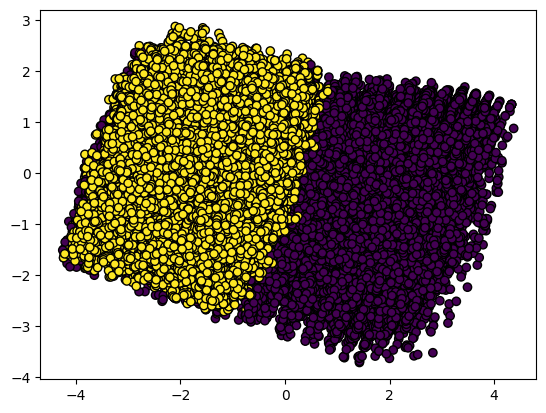

In [155]:
my_pca = my_PCA(n_components=2)
X_pca = my_pca.fit_transform(X_clf)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_clf, edgecolors='k')

In [167]:
from kmeans import my_KMeans

my_kmeans = my_KMeans(k=2)
my_kmeans.fit(X_pca)

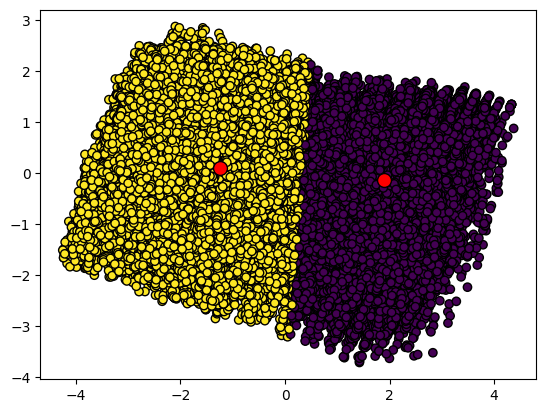

In [168]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=my_kmeans.labels, edgecolor="k")
plt.scatter(my_kmeans.centroids[:,0], my_kmeans.centroids[:,1], s=100, c='red', edgecolor="k")

In [171]:
print('DBS:', davies_bouldin_score(X_pca, my_kmeans.labels))
print('Silhouette:', silhouette_score(X_pca, my_kmeans.labels))
print('ARI:', adjusted_rand_score(y_clf, my_kmeans.labels))
print('NMI:', normalized_mutual_info_score(y_clf, my_kmeans.labels))

DBS: 0.7722863806205976
Silhouette: 0.4986593903987177
ARI: 0.6167742938685513
NMI: 0.5919041878512845


In [ ]:
table_clf

,accuracy,precision,recall,F1
CatBoost (все признаки),0.9392,0.9264,0.9542,0.94
VarianceThreshold,0.9064,0.8510,0.9872,0.91
SelectKBest,0.9270,0.9235,0.9321,0.93
RFE,0.9298,0.9028,0.9614,0.93
PCA,0.9178,0.8658,0.9893,0.92
KernelPCA,0.9150,0.8632,0.9922,0.92
t-SNE,0.5140,0.5095,0.5956,0.55
Isomap,0.5310,0.5460,0.5723,0.56
UMAP,0.9149,0.8625,0.9868,0.92


In [ ]:
table_reg

,MAE,MSE,RMSE,MAPE,R^2
CatBoost (все признаки),774.9440,1.283502e+06,1132.9173,0.2546,0.93
VarianceThreshold,2098.1025,8.310367e+06,2882.7708,0.9138,0.54
SelectKBest,1070.2250,2.279108e+06,1509.6715,0.4775,0.88
RFE,778.4861,1.317306e+06,1147.7396,0.9901,0.93
PCA,1371.0895,3.569541e+06,1889.3228,0.4749,0.80
KernelPCA,1485.2325,4.379569e+06,2092.7419,6.6603,0.76
t-SNE,1619.7968,5.056678e+06,2248.7058,0.5938,0.67
Isomap,3532.7162,1.965330e+07,4433.2043,1.7702,-0.10
UMAP,1664.4982,5.369023e+06,2317.1153,0.9418,0.69


<font size=6>
    <b>Вывод</b>
</font>
<br>
<br>
<font size = 4>
Для данных как в задаче регрессии, так и в задаче классификации при использовании модели CatBoost и различных методов понижения размерности удалось получить достаточно высокую точность работы. CatBoost на полном пространстве признаков показывает наилучшие разультаты, но и после понижения размерности некоторыми методами удалось получить очень приближённую к лучшей оценку.  

В задаче классификации обучение после применения почти всех методов понижения размерности дало хороший и близкий к лучшему результат, из лучших моделей можно выделить:

- <b>RFE:</b> Accuracy: 0.9298	Precision: 0.9028	Recall: 0.9614	F1: 0.93
- <b>SearchKBest:</b> Accuracy: 0.9270	Precision: 0.9235	Recall: 0.9321	F1: 0.93
- <b>PCA:</b> Accuracy: 0.9178	Precision: 0.8658	Recall: 0.9893	F1: 0.92

Не справились только t-SNE и Isomap, после которых значения метрик значительно ухудшились

- <b>t-SNE:</b> Accuracy: 0.5140	Precision: 0.5095	Recall: 0.5095	F1: 0.55
- <b>Isomap:</b> Accuracy: 0.5310	Precision: 0.5460	Recall: 0.5723	F1: 0.56


В задаче регрессии заметен просадок по значению метрик после уменьшения размерности, возможно, это связано с неподходящим выбором числа признаков и неподходящими к данным алгоритмами.

Из хорошо справившихся алгортимов можно выделить RFE и SearchKBest, которые не сильно уступают результату без понижения размерностей

- <b>RFE:</b> MAE: 778.4861, MSE: 1.317306e+06, RMSE: 1147.7396, MAPE: 0.9901, R²: 0.93
- <b>SearchKBest:</b> MAE: 1070.2250, MSE: 2.279108e+06, RMSE: 1509.6715, MAPE: 0.4775, R²: 0.88

Остальные модели показали похожий результат с MSE в районе 3569541-5369023 и R² в районе 0.6-0.8


Сильно хуже остальных модель работает после Isomap, что, вероятно, говорит о том, что этот алгоритм не подходит к данным
- <b>Isomap:</b> MAE: 3532.7162, MSE: 1.965330e+07, RMSE: 4433.2043, MAPE: 1.7702, R²: -0.10
</font>